# Import Data and Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV #hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score


In [2]:
file = '../data/2021-03-21_2157_Val_Top500_Stats.csv'


# Clean Data

In [3]:
def wrangle(data):
    #import data into df
    df = pd.read_csv(data)

    #remove spaces and symbols
    df['Winrate'] = df['Winrate'].str.replace('%', '')
    df['HS%'] = df['HS%'].str.replace('%', '')
    df['Avg.Score'] = df['Avg.Score'].str.replace(',', '')

    #convert numeric strings to floats
    df['Winrate'] = df['Winrate'].astype('float')
    df['HS%'] = df['HS%'].astype('float')
    df['Avg.Score'] = df['Avg.Score'].astype('float')

    # drop high-cardinality feature
    df.drop(columns = ['Rank','Player'], inplace = True)

    # drop region for model clarity

    return df

In [4]:
# load cleaned top 500 data
df = wrangle(file)

In [5]:
df.select_dtypes(include = 'object').nunique()

Class     4
Region    6
dtype: int64

In [6]:
df['Region'].value_counts()

North America    500
Brazil           500
Europe           500
Latin America    500
Asia Pacific     500
Korea            500
Name: Region, dtype: int64

In [7]:
mask = df['Region'] == 'Korea'
df = df.loc[mask]

In [8]:
df.head()

,Rating,Winrate,Games,Avg.Score,HS%,Class,Region
1000,542,54.3,107,4799.0,20.3,Sentinel,Korea
1001,531,56.6,59,5725.0,29.9,Duelist,Korea
1002,498,55.4,30,5474.0,22.6,Duelist,Korea
1003,496,61.0,61,5840.0,26.3,Duelist,Korea
1004,489,51.4,72,5614.0,28.9,Duelist,Korea


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 1000 to 1499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Rating     500 non-null    int64  
 1   Winrate    500 non-null    float64
 2   Games      500 non-null    int64  
 3   Avg.Score  500 non-null    float64
 4   HS%        500 non-null    float64
 5   Class      500 non-null    object 
 6   Region     500 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 31.2+ KB


# Data Analysis

### Rating is heavily skewed right. Even if we look at the log(Rating) its still skewed right. Maybe we only care about Winrate

<AxesSubplot:>

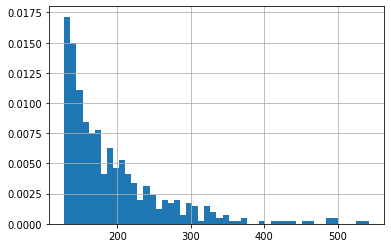

In [10]:
df['Rating'].hist(bins=50, density=True)

<AxesSubplot:>

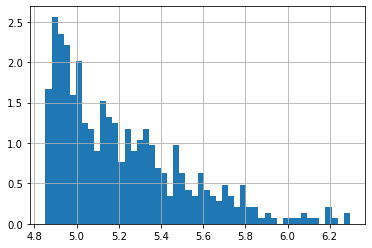

In [11]:
np.log(df['Rating']).hist(bins=50, density=True)

### When looking at Winrate, the log('Winrate') gives a much more even distribution

<AxesSubplot:>

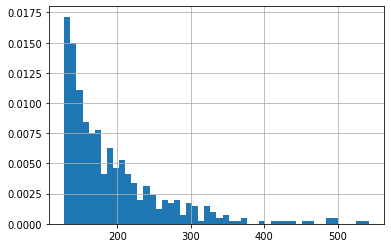

In [13]:
df['Rating'].hist(bins=50, density=True)

<AxesSubplot:>

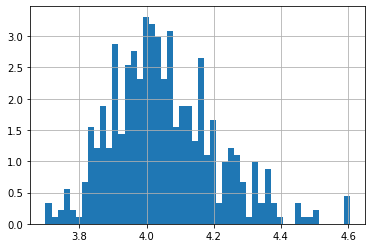

In [12]:
np.log(df['Winrate']).hist(bins=50, density=True)

### Lets identify the categorical and numerical variables

In [19]:
# let's identify the categorical variables
# we will capture those of type *object*

cat_vars = [var for var in df.columns if df[var].dtype == 'O']

print(cat_vars)

['Class', 'Region']


In [21]:
# cast all variables as categorical
df[cat_vars] = df[cat_vars].astype('O')

In [23]:
# now let's identify the numerical variables

num_vars = [
    var for var in df.columns if var not in cat_vars and var != 'Winrate'
]

# number of numerical variables
len(num_vars)

4

## Lets go find out which variables of the dataset contain missing values

In [25]:

# make a list of the variables that contain missing values
vars_with_na = [var for var in df.columns if df[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

df[vars_with_na].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

the dataset has no missing values, which makes sense since we scraped directly from the site

# Target creation and Splitting Data

In [8]:
#Create target variable, set without target, and set with only target
target = 'Winrate'
X = df.drop(columns = target)
y = df[target]

In [9]:
assert len(X) == len(y)

### Split into train, test, val data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=42)
                                                   # 0.25 x 0.8 = 0.2

In [11]:
assert len(X_train + X_test + X_val == len(X))
assert len(y_train + y_test + y_val == len(y))

# Build Model

In [12]:
# Ridge Regression Model
model = make_pipeline(OneHotEncoder(use_cat_names=True),
                      SimpleImputer(strategy = 'mean'),
                      StandardScaler(),
                      Ridge(alpha = 100),
                      )
                                             
model.fit(X_train, y_train)

C:\Users\Eric\.virtualenvs\Val500-Xn8yV5M9\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Class', 'Region'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=100))])

## Randomized Search

In [13]:
# Pipeline Reference for Randomized Search
cf = make_pipeline(OneHotEncoder(use_cat_names=True),
                   SimpleImputer(strategy = 'mean'),
                   StandardScaler(),
                   Ridge()
                   )

# param grid for Randomized Search
param_grid = {
    'simpleimputer__strategy': ['mean', 'median'],
    'ridge__alpha': np.linspace(100,2000, 20)
}


In [14]:
#Randomized Search Model
model_r = RandomizedSearchCV(
    cf,
    param_distributions=param_grid,
    n_iter=60,
    cv=None,
    n_jobs=-1,
    verbose = 1
)

model_r.fit(X_train, y_train)

C:\Users\Eric\.virtualenvs\Val500-Xn8yV5M9\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 40 is smaller than n_iter=60. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
Fitting 5 folds for each of 40 candidates, totalling 200 fits
C:\Users\Eric\.virtualenvs\Val500-Xn8yV5M9\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


RandomizedSearchCV(estimator=Pipeline(steps=[('onehotencoder',
                                              OneHotEncoder(use_cat_names=True)),
                                             ('simpleimputer', SimpleImputer()),
                                             ('standardscaler',
                                              StandardScaler()),
                                             ('ridge', Ridge())]),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'ridge__alpha': array([ 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,
       1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800.,
       1900., 2000.]),
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']},
                   verbose=1)

In [15]:
model_r.best_params_

{'simpleimputer__strategy': 'mean', 'ridge__alpha': 100.0}

# Check Metrics

In [16]:
#Baseline accuracy
y_pred = [y_train.mean()] * len(y_train)
print('Mean Rating:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean Rating: 356.09277777777777
Baseline MAE: 112.3877950617284


In [17]:
# MAE for Ridge Model
print('R = 100 training MAE:', mean_absolute_error(y_train, model.predict(X_train))) 
print('R = 100 val MAE:', mean_absolute_error(y_val, model.predict(X_val)))
print('R = 100 test MAE:', mean_absolute_error(y_test, model.predict(X_test)))


R = 100 training MAE: 54.30937670792244
R = 100 val MAE: 53.65399551424966
R = 100 test MAE: 54.123523940431525


In [18]:
# R2 Score for Ridge Model

print('R = 600 training R2:', r2_score(y_train, model.predict(X_train))) 
print('R = 600 val R2:', r2_score(y_val, model.predict(X_val)))
print('R = 600 test R2:', r2_score(y_test, model.predict(X_test)))

R = 600 training R2: 0.7225196156618663
R = 600 val R2: 0.7197167197848638
R = 600 test R2: 0.7197001211645172


# Feature Importance

In [19]:
# Grab features and coefficients from ridge model
coefficients = model['ridge'].coef_
features = model['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)

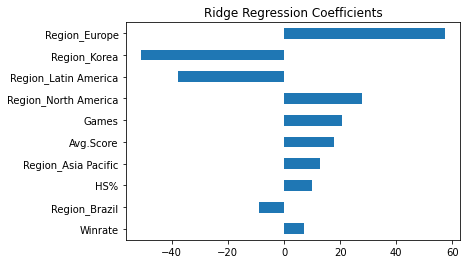

In [20]:
#Looks better. graph below shows why longitude matters
feat_imp.tail(10).plot(kind='barh')
plt.title('Ridge Regression Coefficients')
plt.show()